# Inca Tribe Housing Price Prediction: Introduction

This notebook provides a workflow for analyzing and modeling real estate data from the Inca Tribe housing market. The primary goal is to understand the factors that influence property prices and to build predictive models that can accurately estimate the price of a house based on its features.

**Problem Statement:**
The real estate market is complex, with property prices influenced by a variety of factors such as location, property type, area, number of bedrooms and bathrooms, and more. Accurately predicting house prices is valuable for buyers, sellers, and developers to make informed decisions, optimize investments, and identify market trends.

**Why Price as the Target?**
Price is the most critical outcome variable in real estate analytics, as it directly reflects the market value of a property. By using price as the target, this analysis aims to:
- Quantify the impact of different features on property value
- Enable data-driven pricing strategies
- Support fair and transparent transactions

Throughout this notebook, we will clean and preprocess the data, engineer relevant features, explore relationships, and compare multiple machine learning models to predict housing prices as accurately as possible.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
data = pd.read_csv('Inca Tribe House Prices.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27322 entries, 0 to 27321
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            27322 non-null  object 
 1   Price           27322 non-null  int64  
 2   Bedrooms        27119 non-null  float64
 3   Bathrooms       27151 non-null  float64
 4   Area            26851 non-null  float64
 5   Furnished       27322 non-null  object 
 6   Level           27322 non-null  object 
 7   Compound        27322 non-null  object 
 8   Payment_Option  27322 non-null  object 
 9   Delivery_Date   27322 non-null  object 
 10  Delivery_Term   27322 non-null  object 
 11  City            27322 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 2.5+ MB


In [4]:
data.Delivery_Term.unique()

array(['Finished', 'Unknown ', 'Core & Shell', 'Not Finished',
       'Semi Finished'], dtype=object)

In [5]:
# normalize all object type columns - lower case and strip whitespace
def normalize_column(col):
    if col.dtype == 'object':
        return col.str.lower().str.strip()
    return col

data = data.apply(normalize_column)

# replace all columns with the value unknown with np.nan
data.replace('unknown', np.nan, inplace=True)
data.replace('unknown payment', np.nan, inplace=True)

In [6]:
# identify missing values
missing_values = data.isnull().sum()
missing_values

Type                  0
Price                 0
Bedrooms            203
Bathrooms           171
Area                471
Furnished          8491
Level             10400
Compound          11032
Payment_Option     3012
Delivery_Date     10072
Delivery_Term      4670
City                  0
dtype: int64

Exploring categorical values

In [7]:
# for object columns count the number of unique values
object_columns = data.select_dtypes(include=['object']).columns
for column in object_columns:
    unique_values = data[column].nunique()
    print(f"Column: {column}, Unique Values: {unique_values}")

Column: Type, Unique Values: 9
Column: Furnished, Unique Values: 2
Column: Level, Unique Values: 13
Column: Compound, Unique Values: 559
Column: Payment_Option, Unique Values: 3
Column: Delivery_Date, Unique Values: 9
Column: Delivery_Term, Unique Values: 4
Column: City, Unique Values: 179


In [8]:
data.Delivery_Date.unique()

array(['ready to move', 'soon', '2024', 'within 6 months', '2026', nan,
       '2023', '2025', '2022', '2027'], dtype=object)

In [9]:
data.Payment_Option.unique()

array(['cash', nan, 'installment', 'cash or installment'], dtype=object)

In [10]:
data.drop(['Compound', 'City', 'Delivery_Date'], axis=1, inplace=True)

In [11]:
data['Type'].value_counts()

Type
apartment            8506
chalet               6593
stand alone villa    4629
town house           3073
twin house           2276
duplex                861
standalone villa      608
penthouse             526
studio                250
Name: count, dtype: int64

In [12]:
data['Type'] = data['Type'].str.lower()
data['Type'].replace({'standalone villa': 'stand alone villa'}, inplace=True)

In [13]:
# group level and type
data.loc[pd.isna(data.Level)==True].groupby(['Type']).size()

Type
chalet                868
duplex                 22
penthouse              27
stand alone villa    4869
studio                 11
town house           2648
twin house           1955
dtype: int64

In [14]:
data.loc[data.Type=='penthouse'].groupby(['Level', 'Type']).size()

Level    Type     
1        penthouse     33
10       penthouse      2
10+      penthouse      2
2        penthouse    122
3        penthouse    142
4        penthouse     81
5        penthouse     34
7        penthouse      1
ground   penthouse     15
highest  penthouse     67
dtype: int64

In [15]:
data.groupby(['Delivery_Term'])['Price'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Delivery_Term,,,,,,,,
not finished,1852.0,5.992371e+06,6.458882e+06,50000.0,1697500.0,4500000.0,7800000.0,69000000.0
core & shell,931.0,5.983077e+06,6.615045e+06,30000.0,2250000.0,4000000.0,7300000.0,70000000.0
semi finished,5495.0,5.115295e+06,6.063764e+06,30000.0,1480000.0,3200000.0,6672272.0,100000000.0
finished,14374.0,4.593914e+06,7.090669e+06,30000.0,1000000.0,2600000.0,5200000.0,240000000.0


In [16]:
data.loc[pd.isna(data.Delivery_Term)==True].groupby(['Type']).size().sort_values(ascending=False)

Type
apartment            1421
stand alone villa    1065
chalet                869
town house            712
twin house            395
duplex                114
penthouse              59
studio                 35
dtype: int64

In [17]:
data.groupby('Type')['Delivery_Term'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

Type
apartment            finished
chalet               finished
duplex               finished
penthouse            finished
stand alone villa    finished
studio               finished
town house           finished
twin house           finished
Name: Delivery_Term, dtype: object

In [18]:
data.groupby(['Payment_Option'])['Price'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Payment_Option,,,,,,,,
cash,9573.0,6.919202e+06,8.853694e+06,30000.0,1700000.0,4000000.0,9000000.0,240000000.0
installment,3897.0,4.162045e+06,5.414211e+06,74000.0,1700000.0,3000000.0,5139000.0,205000000.0
cash or installment,10840.0,3.087608e+06,3.999324e+06,30000.0,600000.0,1995420.0,4100000.0,75000000.0


In [19]:
data.loc[data.Type=='penthouse'].groupby(['Level'])['Price'].describe().sort_values('max', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
highest,67.0,3.599196e+06,3.077885e+06,525000.0,2234000.0,3300000.0,4120000.0,25000000.0
1,33.0,5.190333e+06,3.523356e+06,1200000.0,2990000.0,4300000.0,6500000.0,19500000.0
4,81.0,3.443433e+06,2.363981e+06,280000.0,1650000.0,3300000.0,4500000.0,14357745.0
ground,15.0,4.613687e+06,3.452624e+06,430000.0,2582500.0,3800000.0,6540000.0,13000000.0
2,122.0,2.989612e+06,1.860847e+06,125000.0,2117500.0,2859739.5,3500000.0,12500000.0
3,142.0,3.665570e+06,2.138271e+06,225000.0,2281000.0,3400000.0,4556000.0,10718400.0
5,34.0,2.948453e+06,2.090246e+06,320000.0,1641000.0,2575000.0,4113750.0,8650000.0
10,2.0,5.650000e+06,2.050610e+06,4200000.0,4925000.0,5650000.0,6375000.0,7100000.0
7,1.0,5.085000e+06,NaN,5085000.0,5085000.0,5085000.0,5085000.0,5085000.0


In [20]:
data.loc[data.Type=='stand alone villa'].groupby(['Level', 'Type']).size()

Level    Type             
1        stand alone villa     11
2        stand alone villa     22
3        stand alone villa      4
ground   stand alone villa    330
highest  stand alone villa      1
dtype: int64

In [21]:
data.loc[data.Type=='town house'].groupby(['Level', 'Type']).size()

Level   Type      
1       town house     26
2       town house     10
3       town house      2
4       town house      1
7       town house      1
ground  town house    385
dtype: int64

In [22]:
data.loc[data.Type=='twin house'].groupby(['Level', 'Type']).size()

Level   Type      
1       twin house     10
2       twin house     12
4       twin house      1
ground  twin house    298
dtype: int64

In [23]:
data.loc[data['Type'] == 'chalet', 'Level'].mode().to_list()[0]

'1'

In [24]:
modal_levels_by_type = {}
for Type in data['Type'].unique():
    modal_levels_by_type[Type] = data.loc[data['Type'] == Type, 'Level'].mode().to_list()[0]
    
modal_levels_by_type

{'chalet': '1',
 'apartment': '2',
 'stand alone villa': 'ground',
 'studio': 'ground',
 'twin house': 'ground',
 'town house': 'ground',
 'duplex': 'ground',
 'penthouse': '3'}

In [25]:
modal_levels_by_type['penthouse'] = 'highest'

In [26]:
# identify missing values
missing_values = data.isnull().sum()
missing_values

Type                  0
Price                 0
Bedrooms            203
Bathrooms           171
Area                471
Furnished          8491
Level             10400
Payment_Option     3012
Delivery_Term      4670
dtype: int64

In [27]:
# evaluate proportion of missing values to total
missing_proportion = missing_values / len(data)
missing_proportion = missing_proportion[missing_proportion > 0]
missing_proportion = missing_proportion.sort_values(ascending=False)
missing_proportion

Level             0.380646
Furnished         0.310775
Delivery_Term     0.170925
Payment_Option    0.110241
Area              0.017239
Bedrooms          0.007430
Bathrooms         0.006259
dtype: float64

In [28]:
correlation = data['Bedrooms'].corr(data['Bathrooms'])
print(f"Correlation between Bedrooms and Bathrooms: {correlation:.2f}")

Correlation between Bedrooms and Bathrooms: 0.83


Handling null values

In [ ]:
# replace missing values in level with the modal value
# data['Level'] = data['Level'].fillna(data['Type'].map(modal_levels_by_type))

In [ ]:
# calculate the mode of bathrooms per bedroom
bathrooms_per_bedroom = data.groupby('Bedrooms')['Bathrooms'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
bathrooms_per_bedroom = bathrooms_per_bedroom.to_dict()
# calculate the mode of bedrooms per bathroom
bedrooms_per_bathroom = data.groupby('Bathrooms')['Bedrooms'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
bedrooms_per_bathroom = bedrooms_per_bathroom.to_dict()
# calculate the average area by type
average_area_by_type = data.groupby('Type')['Area'].mean()
average_area_by_type = average_area_by_type.to_dict()

# calculate mode of bedrooms per type
bedrooms_by_type = data.groupby('Type')['Bedrooms'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
bedrooms_by_type = bedrooms_by_type.to_dict()

# calculate mode of bathrooms per type
bathrooms_by_type = data.groupby('Type')['Bathrooms'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
bathrooms_by_type = bathrooms_by_type.to_dict()

# fill missing values in Bathrooms based on the average number of bathrooms per bedroom
for bedroom, bathrooms in bathrooms_per_bedroom.items():
    data.loc[(data['Bedrooms'] == bedroom) & (data['Bathrooms'].isnull()), 'Bathrooms'] = bathrooms

# fill missing values in Bedrooms based on the average number of bedrooms per bathroom
for bathroom, bedroom in bedrooms_per_bathroom.items():
    data.loc[(data['Bathrooms'] == bathroom) & (data['Bedrooms'].isnull()), 'Bedrooms'] = bedroom

# fill missing values in Area based on the average area by type
for Type, avg_area in average_area_by_type.items():
    data.loc[(data['Type'] == Type) & (data['Area'].isnull()), 'Area'] = avg_area

# fill missing values in Bedrooms based on the average number of bedrooms per type
for Type, bedroom in bedrooms_by_type.items():
    data.loc[(data['Type'] == Type) & (data['Bedrooms'].isnull()), 'Bedrooms'] = bedroom

# fill missing values in Bathrooms based on the average number of bathrooms per type
for Type, bathrooms in bathrooms_by_type.items():
    data.loc[(data['Type'] == Type) & (data['Bathrooms'].isnull()), 'Bathrooms'] = bathrooms


In [63]:
average_bathrooms_per_bedroom

{1.0: 1.0,
 2.0: 2.0,
 3.0: 2.0,
 4.0: 4.0,
 5.0: 5.0,
 6.0: 6.0,
 7.0: 7.0,
 8.0: 7.0,
 9.0: 9.0,
 10.0: 10.0}

Catchall logic

In [30]:
for column in missing_proportion.index:
    if missing_proportion[column] > 0.4:
        # drop columns with more than 40% missing values
        print(f"Dropping column: {column} with {missing_proportion[column]:.2%} missing values")
        data.drop(columns=[column], inplace=True)
    elif missing_proportion[column] > 0.2 and data[column].dtype == 'object':
        # use unknown for categorical columns with more than 20% missing values
        data[column].fillna('unknown', inplace=True)
    elif data[column].dtype == 'object':
            data[column].fillna(data[column].mode()[0], inplace=True)

In [31]:
# rounding values where it does not make sense to have decimals
data['Bathrooms']= data['Bathrooms'].round()
data['Bedrooms']= data['Bedrooms'].round()

In [32]:
data.isnull().sum()

Type              0
Price             0
Bedrooms          0
Bathrooms         0
Area              0
Furnished         0
Level             0
Payment_Option    0
Delivery_Term     0
dtype: int64

In [33]:
# for object columns count the number of unique values
object_columns = data.select_dtypes(include=['object']).columns
for column in object_columns:
    unique_values = data[column].nunique()
    print(f"Column: {column}, Unique Values: {unique_values}")

Column: Type, Unique Values: 8
Column: Furnished, Unique Values: 3
Column: Level, Unique Values: 14
Column: Payment_Option, Unique Values: 3
Column: Delivery_Term, Unique Values: 4


Condensing level categorical values

In [34]:
data.Level.unique()

array(['unknown', '4', 'ground', '3', '2', '1', '9', '6', '10+', '7', '8',
       '10', '5', 'highest'], dtype=object)

In [35]:
# Group level values of 1 - 3 as low floor, 4 - 7 as mid floor and 8 - 10+ as high floor
def categorize_level(level):
    level = level.replace('+', '')
    if level.isdigit():
        level = int(level)
    else:
        return level
    
    if level in [1, 2, 3]:
        return 'low floor'
    elif level in [4, 5, 6, 7]:
        return 'mid floor'
    else:
        return 'high floor'

In [36]:
data['Level'] = data['Level'].apply(categorize_level)

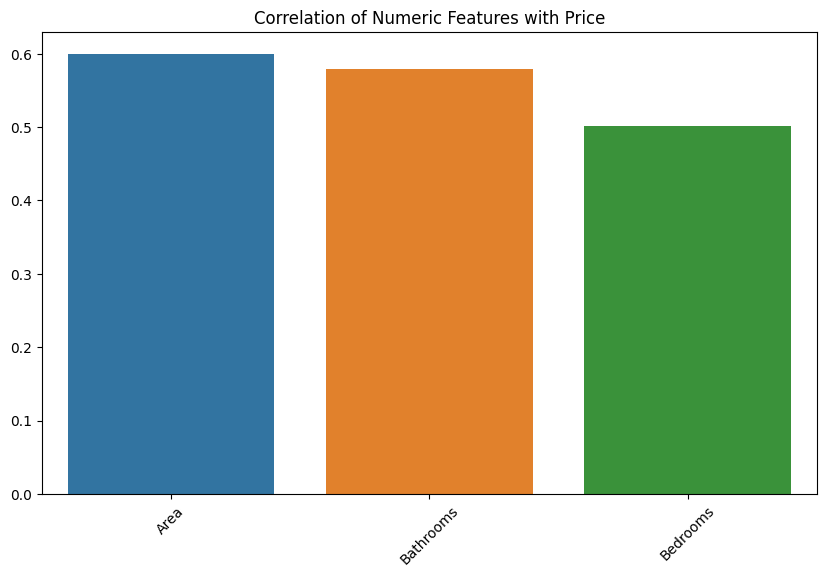

In [37]:
# show a bar chart for the numeric correlation with price
def plot_numeric_correlation(data, target_column):
    numeric_data = data.select_dtypes(include=[np.number])
    correlation = numeric_data.corr()[target_column].sort_values(ascending=False)
    # drop price
    correlation = correlation.drop(target_column)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlation.index, y=correlation.values)
    plt.title(f'Correlation of Numeric Features with {target_column}')
    plt.xticks(rotation=45)
    plt.show()

plot_numeric_correlation(data, 'Price')

### Eta (η) – Categorical vs Numeric Association

**Eta** measures how much variance in a numeric variable is explained by a categorical feature.

- Used when:
  - **Categorical** → independent variable
  - **Numeric** → dependent variable

**Formula**:
$eta = \sqrt{\frac{\text{SS}_{\text{between}}}{\text{SS}_{\text{total}}}}$

**Interpretation**:
- Range: 0 (no association) to 1 (perfect association)
- Rough guide:
  - 0–0.1: Weak
  - 0.1–0.3: Moderate
  - 0.3–0.5: Strong
  - greater than 0.5: Very strong

Use Eta during EDA to evaluate if a categorical feature helps explain variation in a numeric target.

{'Type': 0.30993973547837933, 'Furnished': 0.00910766228302775, 'Level': 0.18600640072845415, 'Payment_Option': 0.056096006311026826, 'Delivery_Term': 0.005105777701848285}


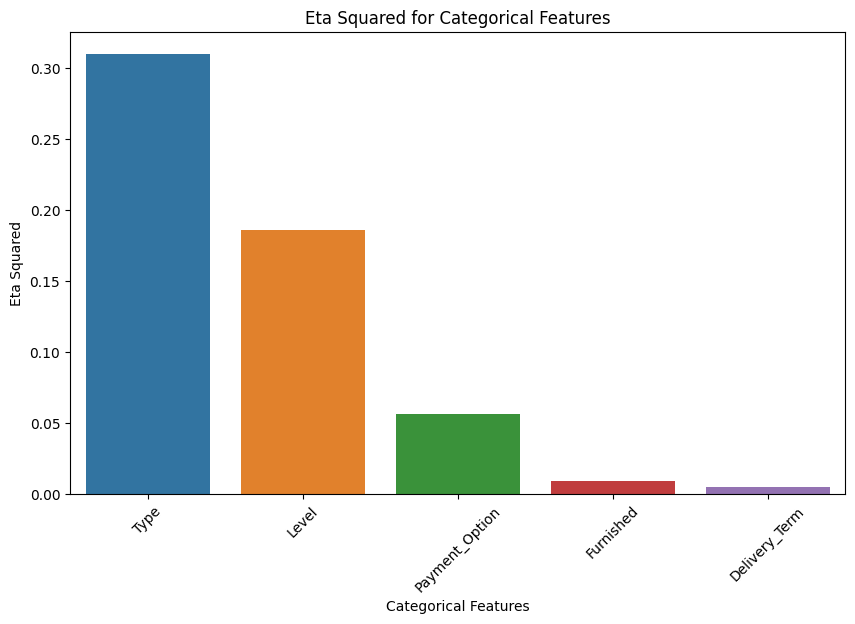

In [38]:
def eta_squared(data, categorical_col, target_col):
    groups = data.groupby(categorical_col)[target_col]
    grand_mean = data[target_col].mean()
    ss_between = sum([len(group) * (group.mean() - grand_mean) ** 2 for name, group in groups])
    ss_total = ((data[target_col] - grand_mean) ** 2).sum()
    return ss_between / ss_total if ss_total != 0 else np.nan

# Example usage for all object columns except the target
eta_sq_results = {}
for col in object_columns:
    if col != 'Price':
        eta_sq_results[col] = eta_squared(data, col, 'Price')

print(eta_sq_results)

# Plotting the eta squared results
def plot_eta_squared(eta_sq_results):
    sorted_eta_sq = dict(sorted(eta_sq_results.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(sorted_eta_sq.keys()), y=list(sorted_eta_sq.values()))
    plt.title('Eta Squared for Categorical Features')
    plt.xlabel('Categorical Features')
    plt.ylabel('Eta Squared')
    plt.xticks(rotation=45)
    plt.show()

plot_eta_squared(eta_sq_results)

Removing Outliers

Text(0.5, 0, 'Type')

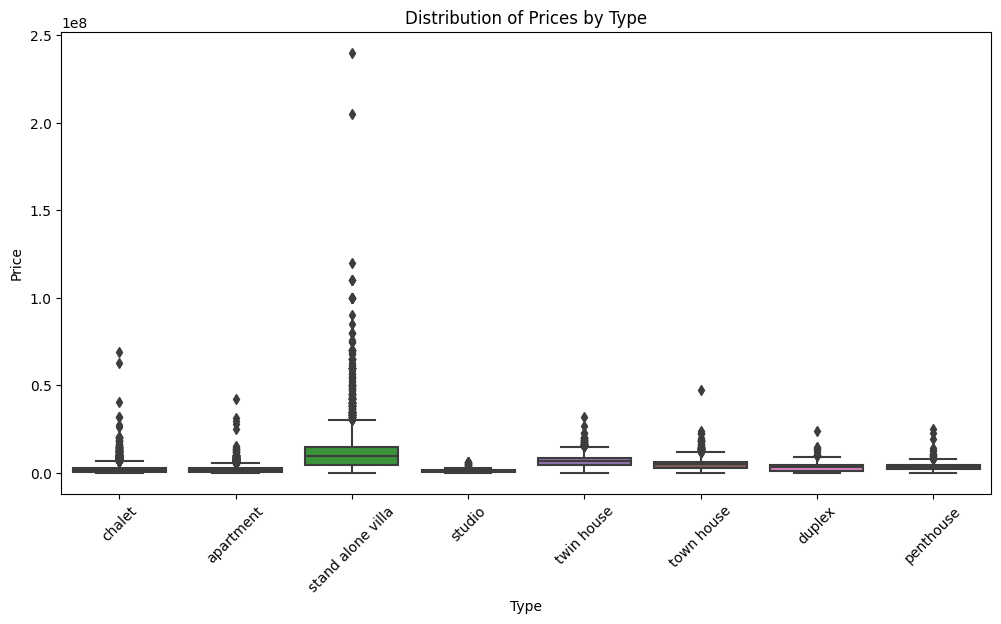

In [39]:
# create a box plot to visualize the distribution of prices by type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type', y='Price', data=data)
plt.xticks(rotation=45)
plt.title('Distribution of Prices by Type')
plt.xlabel('Type')

<Axes: xlabel='Type', ylabel='Price'>

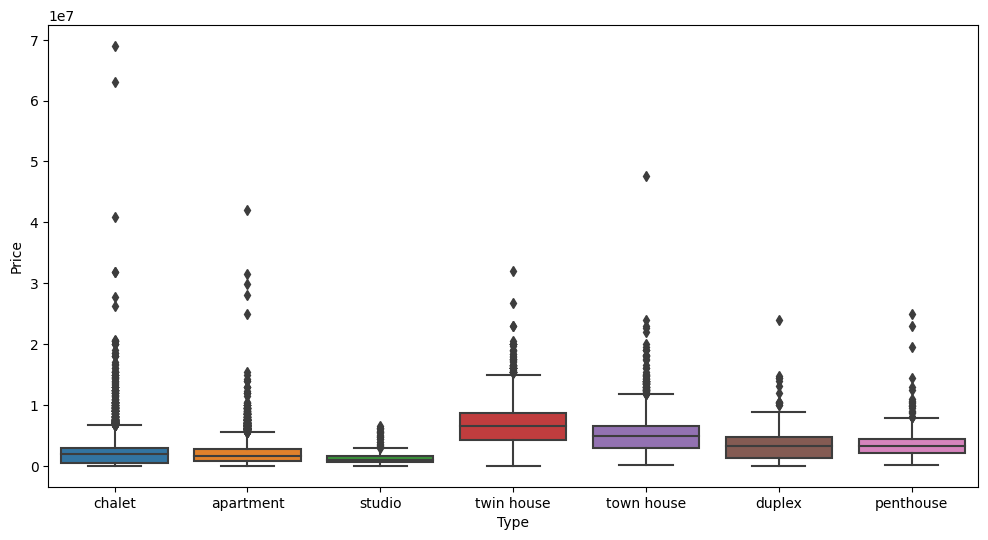

In [40]:
# remove villa from the type and display the plot again

data_filtered = data.loc[data['Type'] != 'stand alone villa']
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type', y='Price', data=data_filtered)

In [41]:
# Remove outliers using IQR method - however iterating through each Type
outliers_removed = data.copy()
indices_to_remove = []
for Type in data['Type'].unique():
    Q1 = data.loc[data.Type==Type]['Price'].quantile(0.25)
    Q3 = data.loc[data.Type==Type]['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    type_indices_to_remove = data[(data['Type'] == Type) & ((data['Price'] < lower_bound) | (data['Price'] > upper_bound))].index
    outliers_removed.drop(type_indices_to_remove, inplace=True)
    indices_to_remove.extend(list(type_indices_to_remove))


print(f"Records before removal: {len(data)}"
      f"\nRecords after removal: {len(outliers_removed)}")

Records before removal: 27322
Records after removal: 26360


Text(0.5, 0, 'Type')

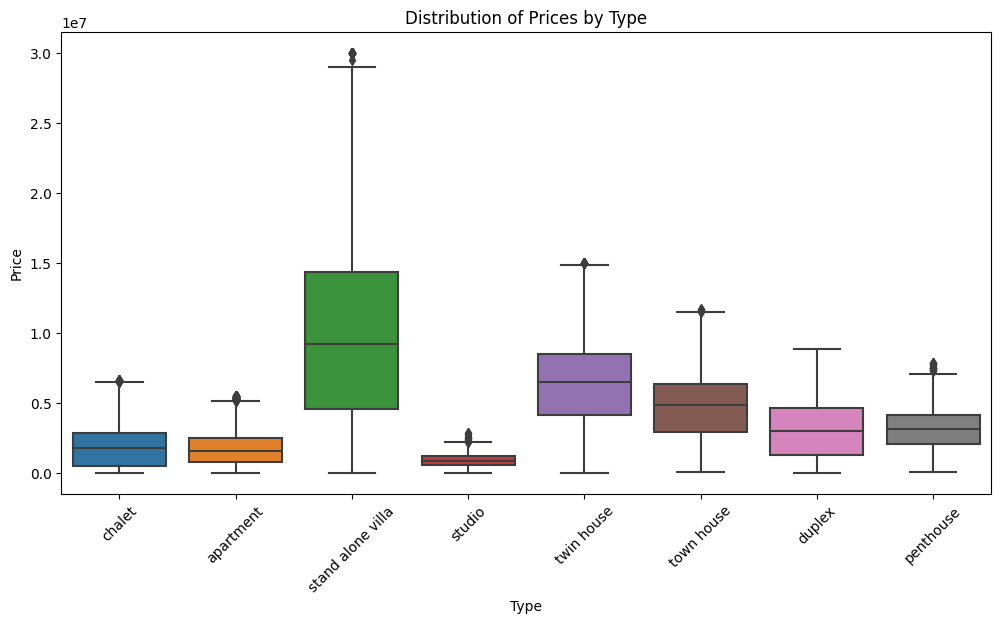

In [42]:
# create a box plot to visualize the distribution of prices by type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type', y='Price', data=outliers_removed)
plt.xticks(rotation=45)
plt.title('Distribution of Prices by Type')
plt.xlabel('Type')

Text(0.5, 1.0, 'Distribution of Prices by Level')

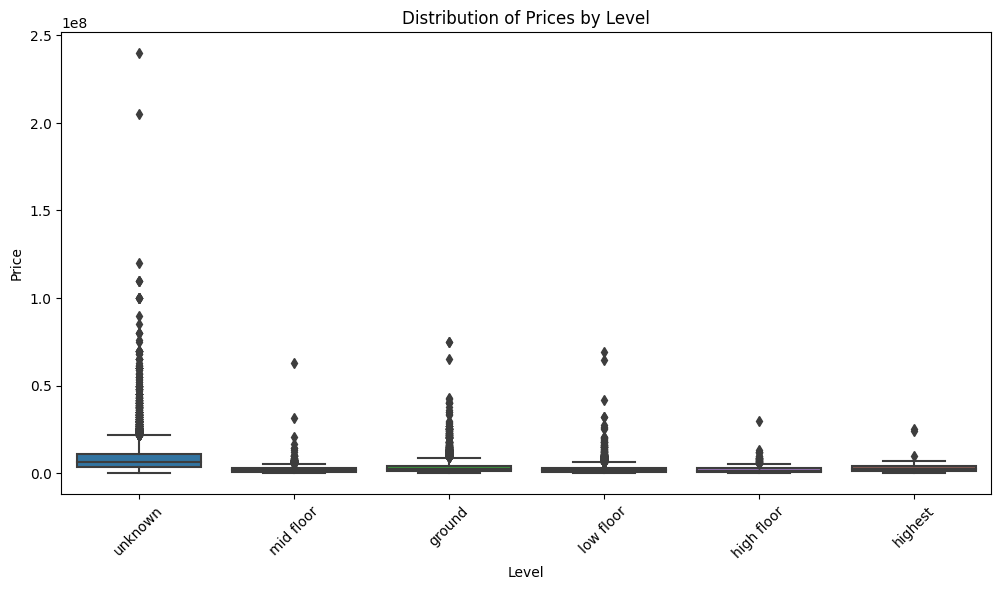

In [43]:
# find correlation between level and price

plt.figure(figsize=(12, 6))
sns.boxplot(x='Level', y='Price', data=data)
plt.xticks(rotation=45)
plt.title('Distribution of Prices by Level')

In [44]:
# Remove outliers using IQR method - however iterating through each Type
outliers_removed = data.copy()
indices_to_remove = []
for level in data['Level'].unique():
    Q1 = data.loc[data.Level==level]['Price'].quantile(0.25)
    Q3 = data.loc[data.Level==level]['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    level_indices_to_remove = data[(data['Level'] == level) & ((data['Price'] < lower_bound) | (data['Price'] > upper_bound))].index
    outliers_removed.drop(level_indices_to_remove, inplace=True)
    indices_to_remove.extend(list(level_indices_to_remove))


print(f"Records before removal: {len(data)}"
      f"\nRecords after removal: {len(outliers_removed)}")

Records before removal: 27322
Records after removal: 25954


Text(0.5, 1.0, 'Distribution of Prices by Level')

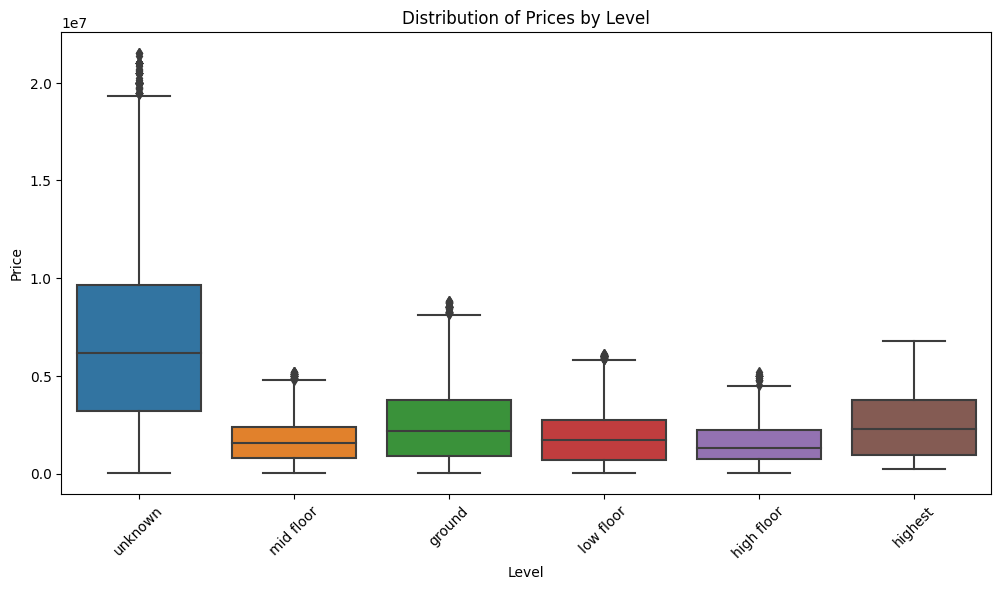

In [45]:
# find correlation between level and price

plt.figure(figsize=(12, 6))
sns.boxplot(x='Level', y='Price', data=outliers_removed)
plt.xticks(rotation=45)
plt.title('Distribution of Prices by Level')

In [46]:
# Union type_indices_to_remove and level_indices_to_remove, ensure unique indices, and drop from DataFrame
indices_to_remove = list(set(indices_to_remove))
outliers_removed = data.drop(indices_to_remove)
print(f"Records before removal: {len(data)}"
        f"\nRecords after removal: {len(outliers_removed)}")


Records before removal: 27322
Records after removal: 25954


Skewness describes the asymmetry of a feature's distribution. When evaluating which scaler to use for preprocessing, understanding skewness is crucial:

MinMaxScaler and StandardScaler assume features are distributed relatively symmetrically (like a bell curve). If a feature is highly skewed, these scalers may not transform the data effectively, and the model may still be influenced by outliers or long tails.

RobustScaler is less sensitive to outliers and skewed distributions because it uses the median and interquartile range (IQR) instead of the mean and standard deviation. This makes it a better choice for features with high skewness or extreme values.

Column: Bedrooms, Skewness: 1.116, Median: 3.0, Mode: 3.0, Mean: 3.188


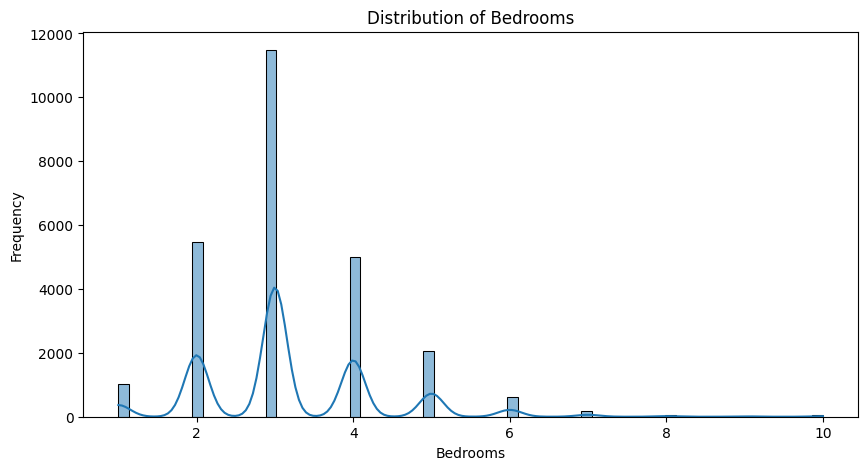

Column: Bathrooms, Skewness: 1.055, Median: 3.0, Mode: 2.0, Mean: 2.736


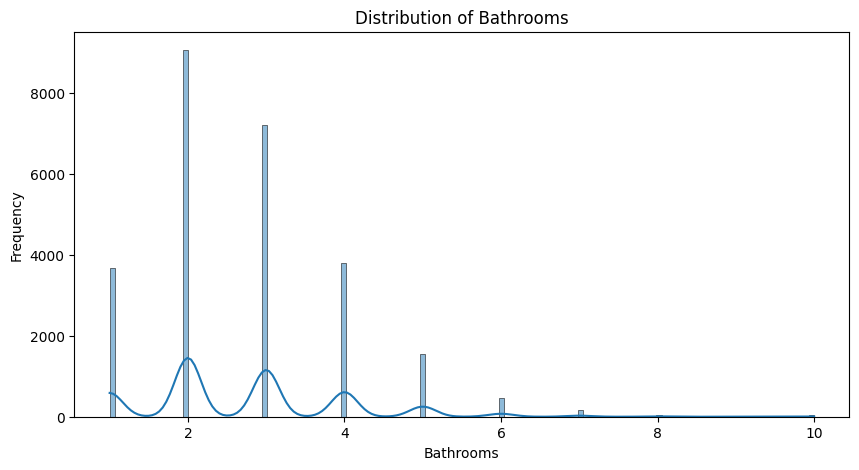

Column: Area, Skewness: 1.890, Median: 174.0, Mode: 120.0, Mean: 223.283


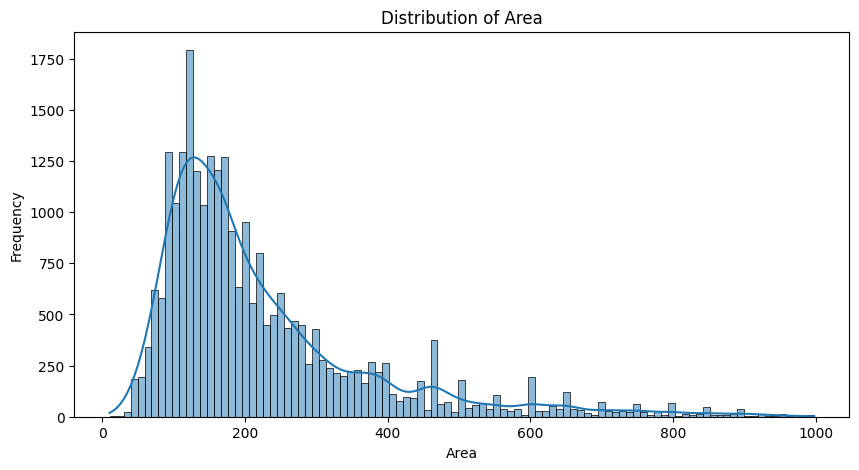

In [47]:
# show the skew and distribution of each numeric column except price, and print median, mode, and average
numeric_columns = outliers_removed.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    if column != 'Price':
        skewness = outliers_removed[column].skew()
        median = outliers_removed[column].median()
        mode = outliers_removed[column].mode()[0]
        mean = outliers_removed[column].mean()
        print(f"Column: {column}, Skewness: {skewness:.3f}, Median: {median}, Mode: {mode}, Mean: {mean:.3f}")
        plt.figure(figsize=(10, 5))
        sns.histplot(outliers_removed[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

In [49]:
from sklearn.preprocessing import OneHotEncoder

# Reset index to ensure proper alignment
outliers_removed_reset = outliers_removed.reset_index(drop=True)

columns_to_scale = ['Bedrooms', 'Bathrooms', 'Area']
numeric_data = outliers_removed_reset.loc[:,columns_to_scale].copy()

# encode categorical columns using one hot encoding
encoded_data = outliers_removed_reset.loc[:,['Type', 'Level']]
# encode data
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
encoded_array = encoder.fit_transform(encoded_data)
encoded_data = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(encoded_data.columns), index=encoded_data.index)

# concatenate the encoded data with the original data
preprocessed_data = pd.concat([numeric_data, encoded_data], axis=1, sort=False)
preprocessed_data['Price'] = outliers_removed_reset['Price']

In [50]:
preprocessed_data

,Bedrooms,Bathrooms,Area,Type_apartment,Type_chalet,Type_duplex,Type_penthouse,Type_stand alone villa,Type_studio,Type_town house,Type_twin house,Level_ground,Level_high floor,Level_highest,Level_low floor,Level_mid floor,Level_unknown,Price
0,2.0,2.0,10.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,70000
1,3.0,3.0,10.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1500000
2,2.0,2.0,12.000000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,3000000
3,3.0,2.0,14.000000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1128000
4,4.0,1.0,20.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25949,4.0,4.0,466.149812,0,0,0,0,1,0,0,0,0,0,0,0,0,1,14000000
25950,4.0,4.0,466.149812,0,0,0,0,1,0,0,0,0,0,0,0,0,1,14000000
25951,4.0,4.0,466.149812,0,0,0,0,1,0,0,0,0,0,0,0,0,1,14500000
25952,4.0,4.0,466.149812,0,0,0,0,1,0,0,0,0,0,0,0,0,1,15000000


Evaluating feature correlation matrix post encoding

Text(0.5, 1.0, 'Feature Correlation Matrix')

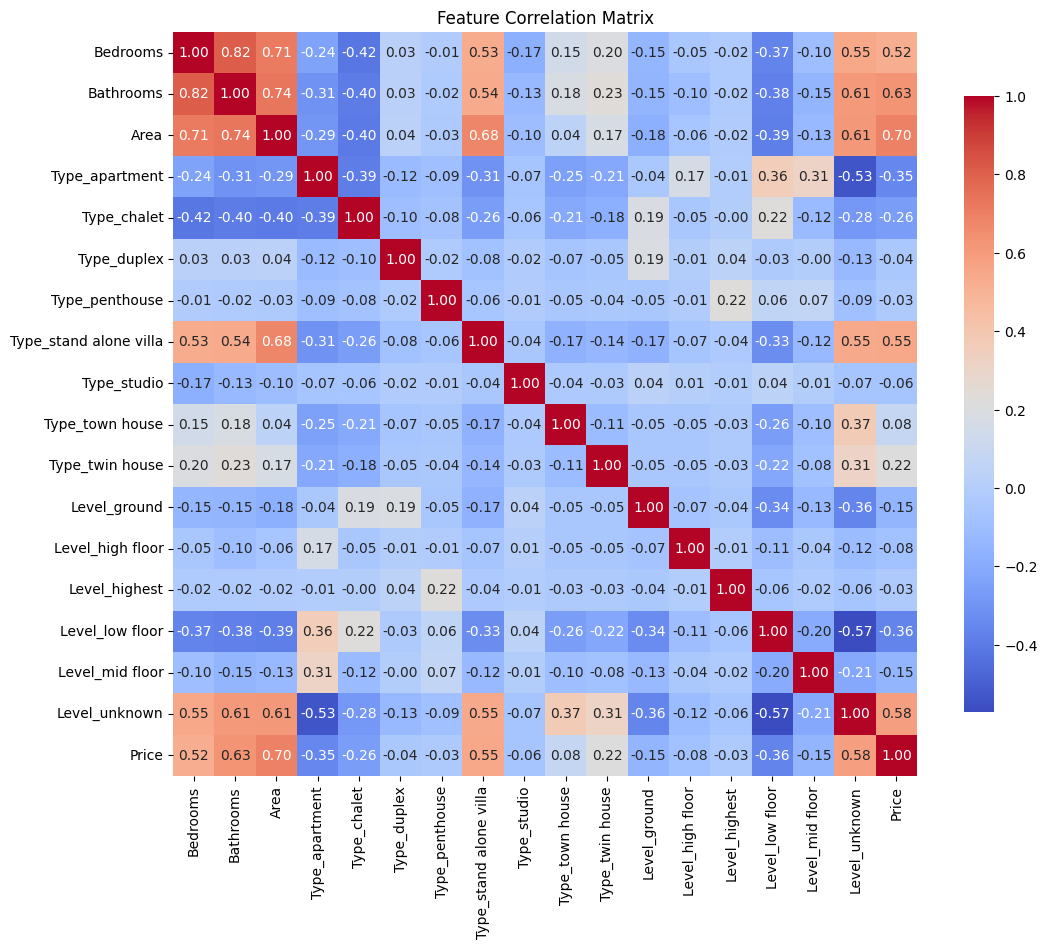

In [51]:
# show feature correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = preprocessed_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')

Model training

In [52]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler, RobustScaler
scaler = RobustScaler()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = preprocessed_data.drop('Price', axis=1)
y = preprocessed_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit minmax scaler to the numeric data in train
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
# now scale the test data using the same scaler
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

model = LinearRegression()

model.fit(X_train, y_train)

# evaluate the model
# add train r2

train_r2 = model.score(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Train R^2 Score: {train_r2}")
print(f"Test R^2 Score: {r2}")

Mean Squared Error: 6965421532433.567
Train R^2 Score: 0.5666085889060675
Test R^2 Score: 0.5559278713821347


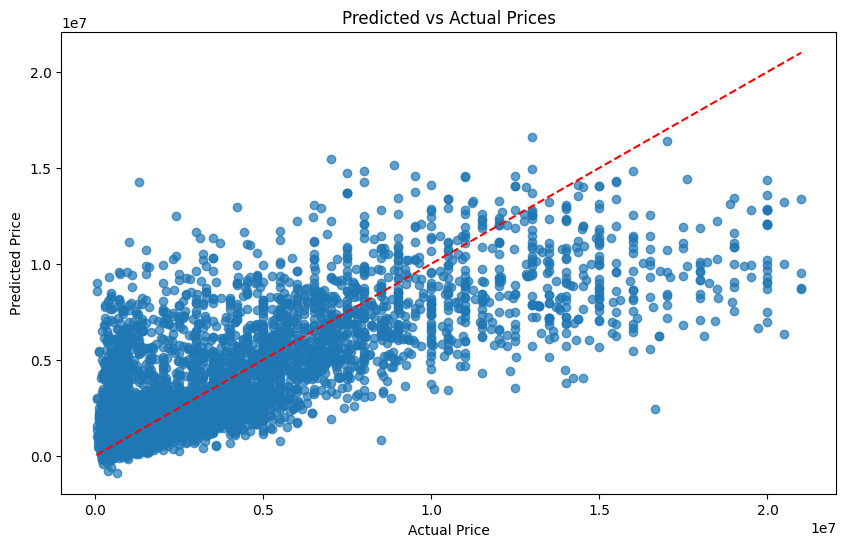

In [53]:
# plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.show()

Huber Mean Squared Error: 7022909392630.227
Huber Train R^2 Score: 0.5608690233207827
Huber Test R^2 Score: 0.5522628015326869


Text(0.5, 1.0, 'Huber Predicted vs Actual Prices')

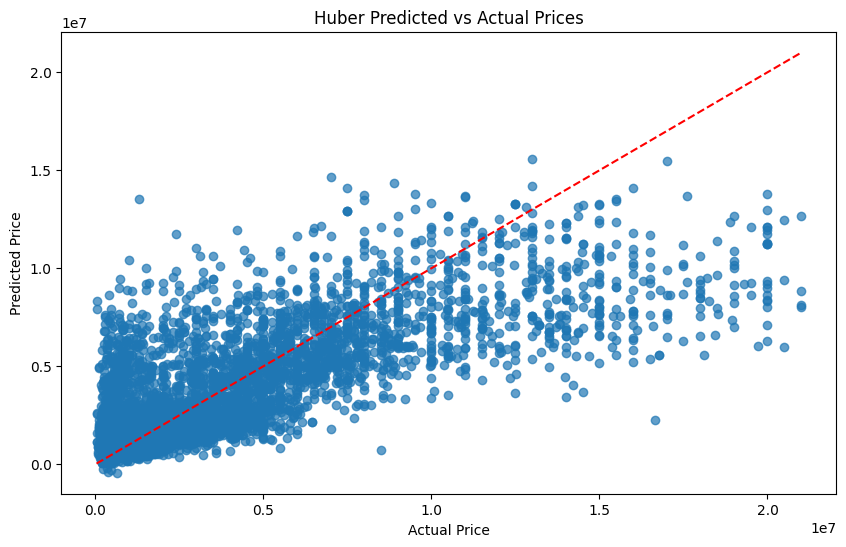

In [54]:
# use huber regression to fit the model
from sklearn.linear_model import HuberRegressor

huber_model = HuberRegressor()

huber_model.fit(X_train, y_train)
# evaluate the model
y_pred = huber_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
train_r2 = huber_model.score(X_train, y_train)
r2 = r2_score(y_test, y_pred)
print(f"Huber Mean Squared Error: {mse}")
print(f"Huber Train R^2 Score: {train_r2}")
print(f"Huber Test R^2 Score: {r2}")
# plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Huber Predicted vs Actual Prices')

Ridge Mean Squared Error: 6959961648291.815
Ridge Train R^2 Score: 0.5667227831770685
Ridge Test R^2 Score: 0.5562759597729874


Text(0.5, 0, 'Actual Price')

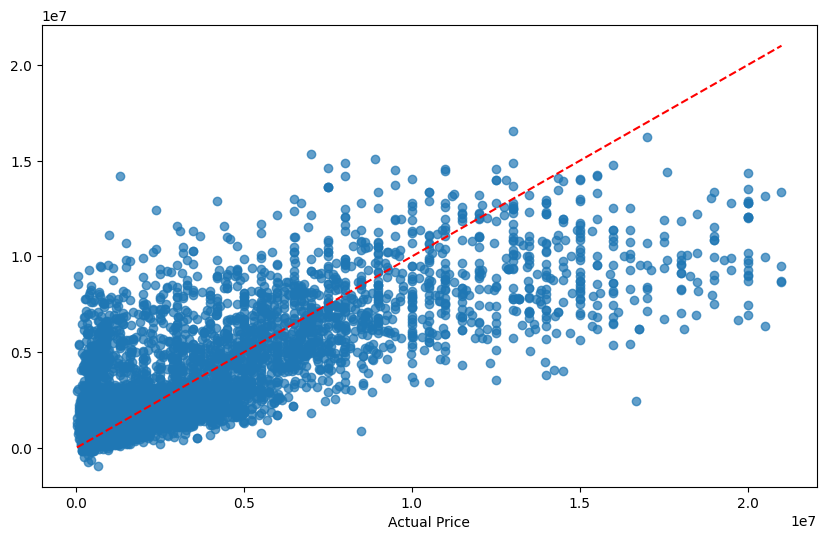

In [55]:
# try ridge regression
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
# evaluate the model

y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_r2 = ridge_model.score(X_train, y_train)

print(f"Ridge Mean Squared Error: {mse}")
print(f"Ridge Train R^2 Score: {train_r2}")
print(f"Ridge Test R^2 Score: {r2}")
# plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')

Random Forest Mean Squared Error: 6356989039206.179
Random Forest Train R^2 Score: 0.6350950784030913
Random Forest Test R^2 Score: 0.5947177581290699


Text(0.5, 1.0, 'Random Forest Predicted vs Actual Prices')

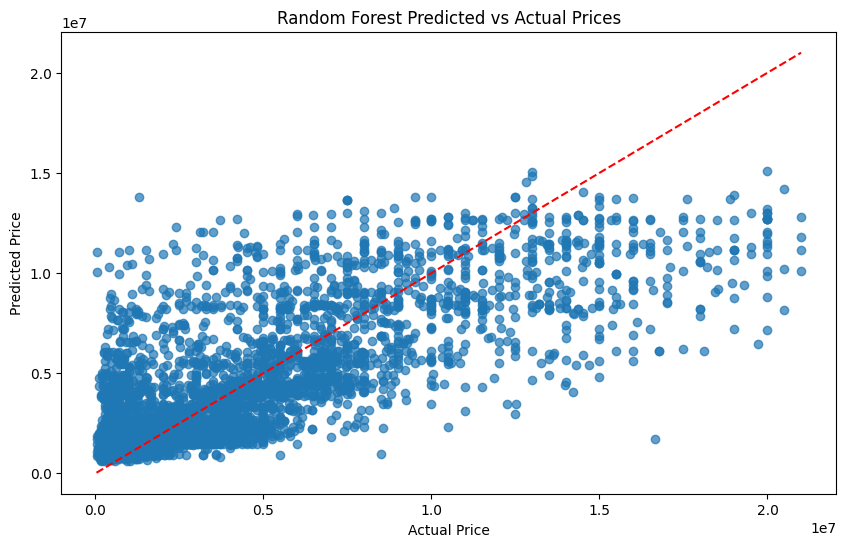

In [57]:
# try random forest regression
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1, criterion='squared_error')
rf_model.fit(X_train, y_train)
# evaluate the model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred) 
train_r2 = rf_model.score(X_train, y_train)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Mean Squared Error: {mse}")
print(f"Random Forest Train R^2 Score: {train_r2}")
print(f"Random Forest Test R^2 Score: {r2}")
# plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest Predicted vs Actual Prices')

In [58]:
# create a summary of the models
model_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Huber Regression', 
              'Ridge Regression', 'Random Forest'],
    'MSE': [ mean_squared_error(y_test, model.predict(X_test)), 
            mean_squared_error(y_test, huber_model.predict(X_test)), 
            mean_squared_error(y_test, ridge_model.predict(X_test)), 
            mean_squared_error(y_test, rf_model.predict(X_test))],
    'R^2': [r2_score(y_test, model.predict(X_test)), 
            r2_score(y_test, huber_model.predict(X_test)), 
            r2_score(y_test, ridge_model.predict(X_test)),
            r2_score(y_test, rf_model.predict(X_test))]
})

print("\nModel Summary:")
print(model_summary)


Model Summary:
               Model           MSE       R^2
0  Linear Regression  6.965422e+12  0.555928
1   Huber Regression  7.022909e+12  0.552263
2   Ridge Regression  6.959962e+12  0.556276
3      Random Forest  6.356989e+12  0.594718


In [62]:
# display the feature importances for the random forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
                   Feature  Importance
2                     Area    0.751537
1                Bathrooms    0.117415
16           Level_unknown    0.082821
0                 Bedrooms    0.019799
3           Type_apartment    0.007454
9          Type_town house    0.006768
7   Type_stand alone villa    0.006584
10         Type_twin house    0.002581
4              Type_chalet    0.001957
11            Level_ground    0.001686
5              Type_duplex    0.000428
6           Type_penthouse    0.000342
14         Level_low floor    0.000327
15         Level_mid floor    0.000148
12        Level_high floor    0.000103
13           Level_highest    0.000036
8              Type_studio    0.000013


Serialize model

In [59]:
# save the random forest model
import joblib

joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [60]:
# serialize encoder
joblib.dump(encoder, 'encoder.joblib')
# serialize scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']